In [36]:
%matplotlib inline
from scipy import linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image
from math import (log,ceil,floor)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from numpy.linalg import matrix_power
import networkx as nx
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from qiskit.circuit.library import QFT
style = {'figwidth':10,'fontsize':17,'subfontsize':14}
styleWide = {'figwidth':25,'fontsize':17,'subfontsize':14}

plt.rcParams['figure.figsize'] = 11,8
matplotlib.rcParams.update({'font.size' : 15})

import warnings
warnings.filterwarnings("ignore")

In [31]:
def circulantAdjacency(n,v):
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]    
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

n_cycle = 8
cCycle = [0,1] + [0 for x in range(n_cycle-3)] + [1] 
ACycle = circulantAdjacency(n_cycle,cCycle)
GCycle = nx.from_numpy_matrix(np.array(ACycle))  

n_complete = 8
cComplete = [0] + [1 for x in range(n_complete-1)] 
A = circulantAdjacency(n_complete,cComplete)
GComplete = nx.from_numpy_matrix(np.array(A))  


$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$
# Quantum Random Walks
## by Jaime Pereira Santos

Fazer introducao com Turing, algoritmos probabilisticos e random walk classica.

## Coined Quantum Walk

In [32]:
#Coined Simulation Functions
def coins(Matrix):
    if Matrix == "H":
        coin = np.array([[1/np.sqrt(2) , 1/np.sqrt(2)],[1/np.sqrt(2) , -1/np.sqrt(2)]])
    elif Matrix == "X":
        coin = np.array([0,1],[1,0])
    return coin

def init_state(N,P,CoinState):
    initstate = np.zeros((N,1))
    initstate[P][0] = 1
    g = np.kron(CoinState,initstate)
    return g

def init_coin(init):
    if init == "0":
        psi0 = np.array([[1],[0]])
    if init == "1":
        psi0 = np.array([[0],[1]])
    if init == "01":
        psi0 = np.array([[1/np.sqrt(2)],[(1*1j)/np.sqrt(2)]])
    return psi0

def walk_op(N,state0,state1):
    c00= np.outer(state0,state0)
    c11= np.outer(state1,state1)
    ShiftPlus = np.roll(np.eye(N),1,axis=0)
    ShiftMinus = np.roll(np.eye(N),-1,axis=0)
    Shift = np.kron(c00,ShiftPlus) + np.kron(c11,ShiftMinus) 
    return Shift

def CU_op(coin, shift,N):
    U = shift.dot(np.kron(coin,np.eye(N)))
    return U

def final_state(U,psi0,steps):
    for t in range(0,steps):
        psi0=U.dot(psi0)
    return psi0

def prob_vec(psiN,N):
    probs = np.zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*np.conjugate(psiN[x]) + psiN[N+x]*np.conjugate(psiN[N+x]) #duvida aqui
    return probs

def cqwalk(N,steps,coinstate):
    P = int((N+1)/2)
    state0 = np.array([1,0])
    state1 = np.array([0,1])
    Coin = coins("H")
    shift= walk_op(N,state0,state1)
    U = CU_op(Coin,shift,N)
    psi0 = init_state(N,P,coinstate)
    psiN = final_state(U,psi0,steps)
    probvec = prob_vec(psiN,N)
    return probvec


The space of our coined quantum walk (CQW) is composed by the coin $\mathcal{H_C}$ and walker spaces $\mathcal{H_W}$, therefore

\begin{equation}
\mathcal{H} = \mathcal{H_C} \otimes \mathcal{H_W}
\end{equation}

The principles of the walk are the same as in the classical case; if the coin is tossed and rolls "heads", for example, the system transitions to position  $\ket{x+1}$, otherwise it advances to  $\ket{x-1}$. However, since the system is allowed to be in a superposition of states, it will interfere constructively and destructively with itself, producing a behaviour unlike anything in the classical quantum walk case.

Considering a quantum random walk on a cyclic graph, where each vertex only has 2 neighbors

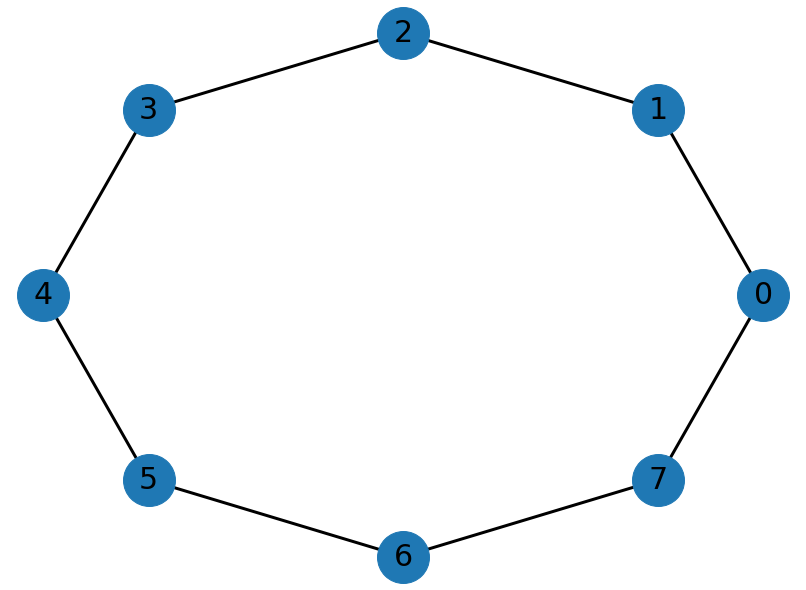

In [17]:
nx.draw_circular(GCycle, with_labels = True,node_size=2700,width=3,font_size=30) 

The coin will be a single qubit unitary operator defined as

\begin{equation}
        \begin{cases}
                C\ket{0}\ket{x} = a\ket{0}\ket{x} + b\ket{1}\ket{x}\\
                C\ket{1}\ket{x} = c\ket{0}\ket{x} + d\ket{1}\ket{x},
        \end{cases}
\end{equation}

where  a, b, c and d are the amplitudes associated with each outcome of the coin toss.

In this example, a balanced coined will be considered, therefore it will simply be the Hadamard operator

\begin{equation}
        C_H = \begin{pmatrix} 
                a & c\\
                b & d
            \end{pmatrix}
            =\frac{1}{\sqrt{2}} \begin{pmatrix}
                                        1 & 1\\
                                        1 & -1
                               \end{pmatrix},
\end{equation}


Blablabla

In [33]:
coin = np.array([[1/np.sqrt(2) , 1/np.sqrt(2)],
              [1/np.sqrt(2), -1/np.sqrt(2)]
             ])
print(coin) 

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


We can describe the shift operator as

\begin{eqnarray}
    S\ket{0}\ket{x} &=& \ket{0}\ket{x+1}\\
    S\ket{1}\ket{x} &=& \ket{1}\ket{x-1} \nonumber
\end{eqnarray}

and S in the computational basis has the format

\begin{equation}
        S = \ket{0}\bra{0} \otimes \sum_{x} \ket{x+1}\bra{x}+ \ket{1}\bra{1} \otimes \sum_{x} \ket{x-1}\bra{x}
\end{equation}

In [27]:
N = 5
c00 = np.outer(np.array([1,0]),np.array([1,0]))
c11 = np.outer(np.array([0,1]),np.array([0,1])) 
  
ShiftPlus = np.roll(np.eye(N),1,axis=0)
ShiftMinus = np.roll(np.eye(N),-1,axis=0)

shift=np.kron(c00,ShiftPlus) + np.kron(c11,ShiftMinus) 
print(shift)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


It follows that the operator that describes the dynamics of the quantum walk will be given by

\begin{equation}
       U = S(C \otimes I_N) \quad \longrightarrow \quad S(C_H\otimes I)
\end{equation}

In [28]:
#TODO: Duvida nesta matriz
U = shift.dot(np.kron(coin,np.eye(N)))
print(U.round(3))

[[ 0.     0.     0.     0.     0.707  0.     0.     0.     0.     0.707]
 [ 0.707  0.     0.     0.     0.     0.707  0.     0.     0.     0.   ]
 [ 0.     0.707  0.     0.     0.     0.     0.707  0.     0.     0.   ]
 [ 0.     0.     0.707  0.     0.     0.     0.     0.707  0.     0.   ]
 [ 0.     0.     0.     0.707  0.     0.     0.     0.     0.707  0.   ]
 [ 0.     0.707  0.     0.     0.     0.    -0.707  0.     0.     0.   ]
 [ 0.     0.     0.707  0.     0.     0.     0.    -0.707  0.     0.   ]
 [ 0.     0.     0.     0.707  0.     0.     0.     0.    -0.707  0.   ]
 [ 0.     0.     0.     0.     0.707  0.     0.     0.     0.    -0.707]
 [ 0.707  0.     0.     0.     0.    -0.707  0.     0.     0.     0.   ]]


Consider a quantum system located at  $\ket{x = 0}$  with coin state  $\ket{0}$ , for  $t=0$ . It's state will be described by

\begin{equation}
        \ket{\psi(0)} = \ket{0}\ket{x=0}.
        \label{eq:coinedQWInitCond0}
\end{equation}

Applying the unitary evolution operator $t$ times

\begin{equation}
      \ket{\Psi(0)}\xrightarrow[]{\text{$U$}}\ket{\Psi(1)}\xrightarrow[]{\text{$U$}}\ket{\Psi(2)}\xrightarrow[]{\text{$U$}} (...) \xrightarrow[]{\text{$U$}}\ket{\Psi(t)}
\end{equation}

will result in state

\begin{equation}
	\ket{\Psi(t)}=U^{t}\ket{\Psi(0)},
\end{equation}

In [34]:
steps = 1
psi0 = init_state(N,int(N/2)+1,init_coin('0'))
psiInit = psi0
psiT = psi0
for t in range(0,steps):
    psi0 = U.dot(psi0)
    psiT = psi0
    
for b,d, c in zip(list(range(2*N)),psiInit, psiT):
    print(np.mod(b,N),d,c)

0 [0.] [0.]
1 [0.] [0.]
2 [0.] [0.]
3 [1.] [0.]
4 [0.] [0.70710678]
0 [0.] [0.]
1 [0.] [0.]
2 [0.] [0.70710678]
3 [0.] [0.]
4 [0.] [0.]


The probability distribution is then obtained by the Born rule
 
\begin{equation}
    p(\ket{\psi(t)}) = \lvert \ket{\psi(t)}  \rvert^2
\end{equation}


In [35]:
probs = np.zeros((N,1))
for x in range(N):
        probs[x] = abs(psiT[x])**2 + abs(psiT[N+x])**2
print(probs)   

[[0. ]
 [0. ]
 [0.5]
 [0. ]
 [0.5]]


Putting it all together, the _cqwalk_ function (available in this notebook) returns a probability distribution ready to be plotted.\par
For this example we consider a CQW, after $100$ steps, on cyclic graph with 200 vertices.

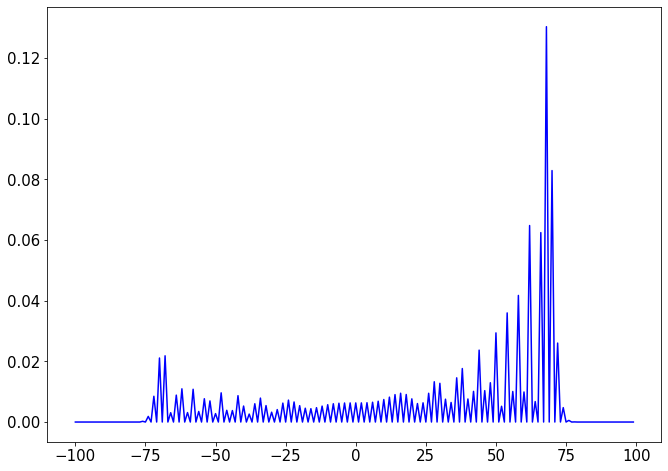

In [43]:
N = 200
steps = 100

initcondcoin0 = init_coin('0')

qw0 = cqwalk(N,steps,initcondcoin0) 

plt.plot(np.arange(-N/2,N/2),qw0 ,'b')
plt.show()

The Hadamard operator flips the sign of state $\ket{1}$, hence more terms are cancelled when the coin state is $\ket{1}$. Since $\ket{0}$ was defined to _increment_ state $\ket{x}$, then it is obvious why there is a higher probability of finding the walker in the right-side of the graph.

Following this logic, it would be expected that an initial condition

\begin{equation}
        \ket{\Psi(0)} = \ket{1}\ket{x=0},
        \label{eq:coinedQWInitCond1}
\end{equation}

would result in more cancelations of terms when the coin state is $\ket{0}$, resulting in a drift towards the left-side.

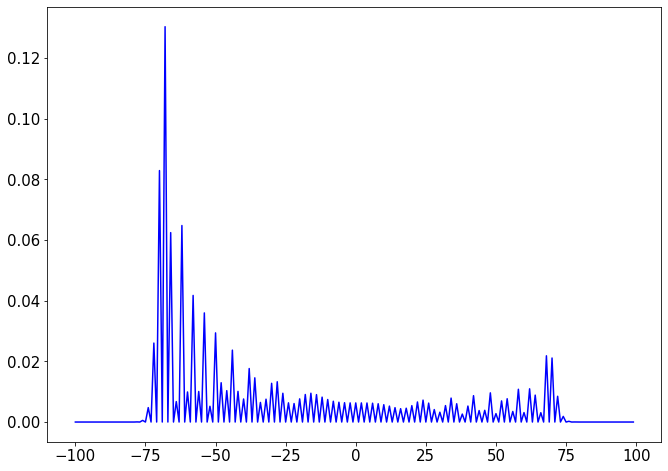

In [38]:
N = 200
steps = 100

init1 = '1'
initcondcoin1 = init_coin(init1)
qw1 = cqwalk(N,steps,initcondcoin1)

plt.plot(np.arange(-N/2,N/2),qw1 ,'b')
plt.show()

In order to obtain a symmetrical distribution, the initial state of the coin must be a superposition. However, in order to not cancel    terms before the calculation of the probability distribution, one must multiply state $\ket{1}$ with the imaginary unit $i$

\begin{equation}
        \ket{\Psi(0)} = \frac{\ket{0}+i\ket{1}}{\sqrt{2}}\ket{x=0}.
        \label{eq:12}
\end{equation}


Tambem podia ser uma moeda em que eliminamos o vies da Hadamard.

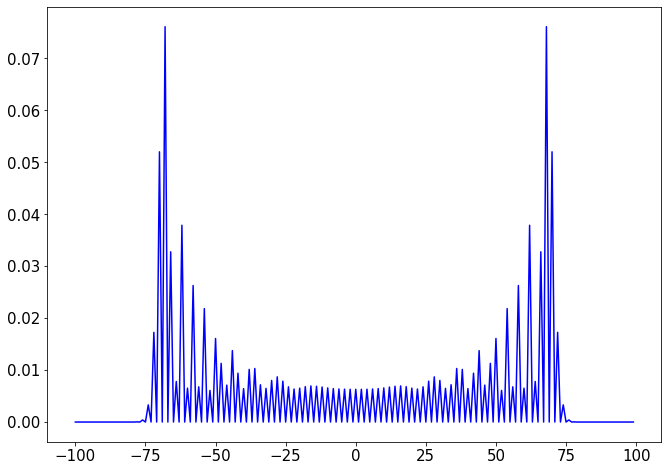

In [39]:
N = 200
steps = 100

init01 = '01'
initcondcoin01 = init_coin(init01)
qw01 = cqwalk(N,steps,initcondcoin01)

plt.plot(np.arange(-N/2,N/2),qw01 ,'b')
plt.show()

In [41]:
%%HTML
<center>
<video width="810" height="570" controls>
  <source src="QuantumWalk500.mp4" type="video/mp4">
</video>

The probability distribution is now symmetric and it is spread over the range $[-\frac{t}{\sqrt{2}},-\frac{t}{\sqrt{2}}]$ with peaks around $x \approx \pm \frac{t}{\sqrt{2}}$. This means that if the position of the walker was measured at the end, it would be equally probable to find him either in the left side or the right side of the graph, which is not possible in a classical diffusive motion.


Escrever sobre desvio padrao e aplicacoes da quantum walk discreta.

### Qiskit Implementation

In [72]:
#Qiskit Functions
def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=3000).result().get_counts()
    return result

#CNot decomposition
def cnx(qc,*qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        #A matrix: (made up of a Z and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu(np.pi/2, 0, 0,0, qubits[-2],qubits[-1])
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        #B matrix (cry again, but opposite angle)
        qc.cu(-np.pi/2, 0, 0,0, qubits[-2], qubits[-1])
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
   # elif len(qubits)==3:
   #     qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)
    return qc

def incr(qwc,q,subnode,n):
    qwc.x(subnode[0])
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qwc,subnode[0],*q[-1::-1])
            #qwc.barrier()
        else:
            cnx(qwc,subnode[0],*q[-1:j:-1])
           # qwc.barrier()
    qwc.x(subnode[0])
    return qwc

def decr(qwc,q,subnode,n):
    c=0
    qwc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            #c+=1
            cnx(qwc,subnode[0],*q[-1::-1])
            #qwc.x(q[c])
            #qwc.barrier()
        else:
            #c+=1
            cnx(qwc,subnode[0],*q[-1:j:-1])
            #if(c==n):
                #break
            #qwc.x(q[c])
            #qwc.barrier()
    qwc.x(q[-1:0:-1])
    return qwc

def runWalk(N,steps,stateVec):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N)
    qsub = QuantumRegister(1)
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    qwc.x(qreg[0])
    for i in range(0,steps):
        qwc.h(qsub[0])
        qwc.p(3*(np.pi)/2)
        qwc.barrier()
        incr(qwc,qreg,qsub,N)
        qwc.barrier()
        decr(qwc,qreg,qsub,N)
        qwc.barrier()
    if not stateVec:
        qwc.measure(qreg,creg)
    return qwc

def circRunWalk(N,steps,toGate):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N,name='node')
    qsub = QuantumRegister(1, name='coin')
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    incrCirc1 = QuantumCircuit(qreg,qsub)
    decrCirc1 = QuantumCircuit(qreg,qsub)
    incrCirc1 = incrCirc(incrCirc1,qreg,qsub,N,toGate)
    decrCirc1 = decrCirc(decrCirc1,qreg,qsub,N,toGate)
    qwc.x(qreg[0])
    qwc.h(qsub[0])
    qwc.barrier()
    for i in range(0,steps):
        qwc.append(incrCirc1,[N]+list(range(0,N)))
        qwc.append(decrCirc1,[N]+list(range(0,N)))
        qwc.barrier()
        if i!=steps-1:
            qwc.h(qsub[0])
    qwc.measure(qreg,creg)
    return qwc

def initialCond(string,N,toGate):
    qc = QuantumCircuit(N+1)
    for x in range(N):
        if string[x] == '1':
            qc.x(x)
    qc.h(N)
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INIT      '
    return qc

def baseResultDict(n,decimal):
    "Retuns a dictionary composed of a range of N keys converted to binary."
    baseDict = {}
    if decimal:
        for decNumber in range(2**n):
            dec = decNumber 
            baseDict[dec] = 0
    else:
        for decNumber in range(2**n):
            decToBin = bin(decNumber)[2:].zfill(ceil(log(2**n,2)))
            baseDict[str(decToBin)] = 0  
    return baseDict

def normalizedResultDict(baseDict,qiskitDict):
    "Returns the result of merging qiskit produced dictionaries with dictionaries produced from multBinResultDict for graph formatting reasons."
    new_d1 = baseDict
    new_d2= qiskitDict
    normalizedResultDict = {**new_d1,**new_d2}
    return normalizedResultDict

def resultsSim(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = baseResultDict(N,Decimal)
    if Decimal:
        correctedResultAux = { int(k[::-1],2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k[::-1] : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult

##
def printIncr(N,steps,style):
    "Creates a single instance of the coined quantum walk cicuit."
    for n in N:
        qreg = QuantumRegister(n,name='node')
        qsub = QuantumRegister(1, name='coin')
        incrCirc1 = QuantumCircuit(qreg,qsub)
        incrCirc1 = incrCirc(incrCirc1,qreg,qsub,n,False)
        fig = incrCirc1.draw(output='mpl',style=style) 
    return fig 

def printDecr(N,steps,style):
    "Creates a single instance of the coined quantum walk cicuit."
    for n in N:
        qreg = QuantumRegister(n,name='node')
        qsub = QuantumRegister(1, name='coin')
        decrCirc1 = QuantumCircuit(qreg,qsub)
        decrCirc1 = decrCirc(decrCirc1,qreg,qsub,n,False)
        fig = decrCirc1.draw(output='mpl',style=style) 
    return fig 

def drawCirc(circMultWalk,style):
    for circList in circMultWalk:
        for circ in circList:
            fig = circ.draw(output='mpl',style=style)
    return fig


def incrCirc(qc,q,subnode,n,toGate):
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qc,subnode[0],*q[-1::-1])
        else:
            cnx(qc,subnode[0],*q[-1:j:-1])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INC      '
    return qc

def decrCirc(qc,q,subnode,n,toGate):
    c=0
    qc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            c+=1
            cnx(qc,subnode[0],*q[-1::-1])
            qc.x(q[c])
        else:
            c+=1
            cnx(qc,subnode[0],*q[-1:j:-1])
            if(c==n):
                break
            qc.x(q[c])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      DEC      '
    return qc

In [73]:
def c_increment(n):
    c_inc = QuantumCircuit(n)
    controls = [x for x in range(n-1)]
    for p in range(n-1):
        c_inc.mcx(controls,controls[-1] + 1)
        controls.pop()
    c_inc.x(0)
    c_inc = c_inc.to_gate()
    c_inc.name = 'INC'
    c_inc = c_inc.control()
    return c_inc
    
def c_decrement(n):
    c_dec = QuantumCircuit(n)
    controls = [x for x in range(n-1)]
    c_dec.x(controls)
    for p in range(n-2):
        c_dec.mcx(controls,controls[-1] + 1)
        c_dec.x(controls[-1])
        controls.pop()   
    c_dec.cx(0,1)
    c_dec = c_dec.to_gate()
    c_dec.name = 'DEC'
    c_dec = c_dec.control()
    return c_dec

def runCoinedWalk(n,steps):
    qw_qc = QuantumCircuit(n+1,n)
    u_inc = c_increment(n)
    u_dec = c_decrement(n)
    #--- Initial Condition
    qw_qc.x(n-1)
    qw_qc.barrier()
    #--- Diffusion
    for t in range(steps):
        qw_qc.h(n)
        qw_qc.x(n)
        qw_qc.append(u_inc, [n]+list(range(0, n)))
        qw_qc.x(n)
        qw_qc.append(u_dec, [n]+list(range(0, n)))
        qw_qc.barrier()
    qw_qc.measure(range(n),range(n))
    return qw_qc


Now, the focus is to study a quantum circuit based on the work presented by \cite{douglaswang07}. This approach relies on a set of gates that shift the state of the walker by $+1$ or $-1$, each with a probability associated with the chosen coin.

<center>
<img src="dwcircuit.png" width="800" height="600"/>

The increment gate will be

<center>
<img src="dwincrement.png" width="500" height="400"/>

and the decrement gate

<center>
<img src="dwdecrement.png" width="500" height="400"/>

The generalized CNOT gates act on the node states as a cyclic permutator, where each vertex is mapped to an adjacent state. This can be seen as the walker moving left or right, in the uni-dimensional graph example. \par
For a graph with $8$ nodes, for example, $3$ qubits are required to encode every vertex and an extra qubit for the coin. For a 3 step walk, we must build 3 sequences of increment and decrement gates, controlled by the coin operator.

In order to implement the Qiskit circuit, we must first find a way of creating generalized CNOT gates. One approach to this problem is to decompose an arbitrarily controlled CNOT gate into elementary gates, as was done by \cite{barenco95}. \par
In this context, the main idea is that for any unitary operator $U$, there exists operators such that

\begin{equation}
	U = \phi AXBXC,
\end{equation}

where $ABC=I$, $X$ is the Pauli-X and $\phi$ is a phase operator described by $\phi=e^{i\delta} \times I$.

<center>
<img src="cnotdecomp.png" width="800" height="600"/>

In order to understand this method, a good first example is the decomposition of the Toffoli gate.

<center>
<img src="toffolidecomp.png" width="800" height="600"/>

In this case

\begin{equation}
\begin{gathered}
 A = R_z(\frac{\pi}{2}) R_y(\frac{\pi}{2}) ,
\\
 B = R_y(-\frac{\pi}{2}),
\\
 C = R_z(-\frac{\pi}{2}) .
\end{gathered}
\end{equation}

where

\begin{equation}
\begin{gathered}
R_z(\theta) = \begin{pmatrix} e^{i\frac{\phi}{2}} & 0 \\ 0 & e^{i\frac{\phi}{2}} \end{pmatrix},
\\\\
R_y(\phi) = \begin{pmatrix}cos(\frac{\theta}{2}) & -sin(\frac{\theta}{2}) \\sin(\frac{\theta}{2}) & cos(\frac{\theta}
{2})\end{pmatrix},\\\\
\phi(\delta) = \begin{pmatrix}
		e^{i\delta} & 0 \\
		0 & e^{i\delta}
		 \end{pmatrix}.
\end{gathered}
\end{equation}

Before applying gate $\phi(\frac{\pi}{2})$, the unitary operation performed on the target qubit, composed of all of the above rotations, will be 

\begin{equation}
	R_z(\frac{\pi}{2})R_y(\frac{\pi}{2})XR_y(-\frac{\pi}{2})XR_z(-\frac{\pi}{2}) = 
	\begin{pmatrix}
		0 & -i \\
		-i & 0
		 \end{pmatrix} \neq X.
\end{equation}

Introducing the phase correction results in

\begin{equation}
	\phi(\frac{\pi}{2}) 
	\begin{pmatrix}
		0 & -i \\
		-i & 0
		 \end{pmatrix} =  
	\begin{pmatrix}
		i & 0 \\
		0 & i
		 \end{pmatrix}   
	\begin{pmatrix}
		0 & -i \\
		-i & 0
		 \end{pmatrix} =   
	\begin{pmatrix}
		0 & 1 \\
		1 & 0
		 \end{pmatrix} = X  
\end{equation}


However,

\begin{equation}
	\begin{pmatrix}
		0 & -i \\
		-i & 0
		 \end{pmatrix} = 	-i \begin{pmatrix}
		0 & 1 \\
		1 & 0
		 \end{pmatrix}
\end{equation}

meaning the phase correction isn't need, since $-i$ is a global phase and has no effect on the result of the measurement.

The increment gate in Qiskit will then be

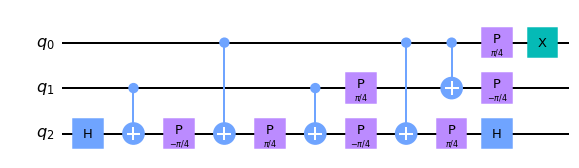

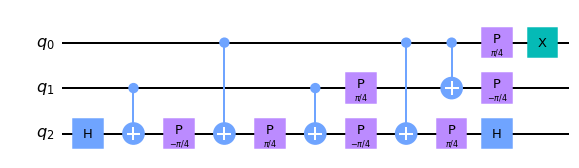

In [69]:
N = 3
incCirc = QuantumCircuit(N)
controls = [x for x in range(N-1)]
for p in range(n-1):
    incCirc.mcx(controls,controls[-1] + 1)
    controls.pop()
incCirc.x(0)
incCirc = transpile(incCirc,basis_gates=['cx','rz','x','p','h'])
incCirc.draw(output='mpl')

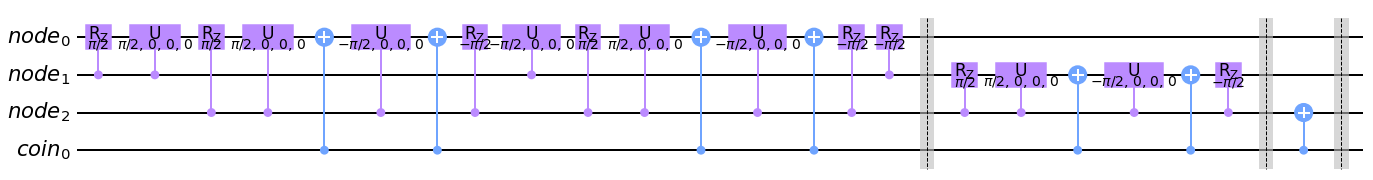

<Figure size 1800x219.509 with 0 Axes>

In [75]:
N = 3
qreg = QuantumRegister(N,name='node')
qcoin = QuantumRegister(1, name='coin')
qincr = QuantumCircuit(qreg,qcoin)

for j in range(-1,N-1):
    if(j==-1):
        cnx(qincr,qcoin[0],*qreg[-1::-1])
    else:
        cnx(qincr,qcoin[0],*qreg[-1:j:-1])
    qincr.barrier()
display(qincr.draw(output='mpl',fold=-1,style=styleWide))
plt.clf()

And the decrement gate

In [56]:
#N = 3
#qreg = QuantumRegister(N,name='qv')
#qcoin = QuantumRegister(1, name='qc')
#qdecr = QuantumCircuit(qreg,qcoin)
#
#qdecr.x(qcoin[0])
#qdecr.x(qreg[-1:0:-1])
#
#for j in range(-1,N-1):
#    if(j==-1):
#        cnx(qdecr,qcoin[0],*qreg[-1::-1])
#    else:
#        cnx(qdecr,qcoin[0],*qreg[-1:j:-1])
#    qdecr.barrier()
#
#qdecr.x(qreg[-1:0:-1])
#qdecr.x(qcoin[0])
#
#display(qdecr.draw(output='mpl',fold=-1,style=styleWide))
#plt.clf()

In [16]:
#def increment_gate(qwc, q, subnode):
#    cnx(qwc, subnode[0], q[2], q[1], q[0])
#      cnx(qwc, subnode[0], q[2], q[1])
#        cnx(qwc, subnode[0], q[2])
#        qwc.barrier()
#        return qwc

Now that we have all the operations required to perform the walk, let's see the probability distributions that result from running this circuit multiple times with initial condition $\ket{\psi(0)} = \ket{0}\ket{x=4}$ and the Hadamard coin.\par
The full circuit will be

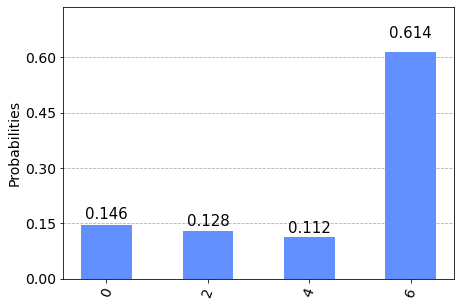

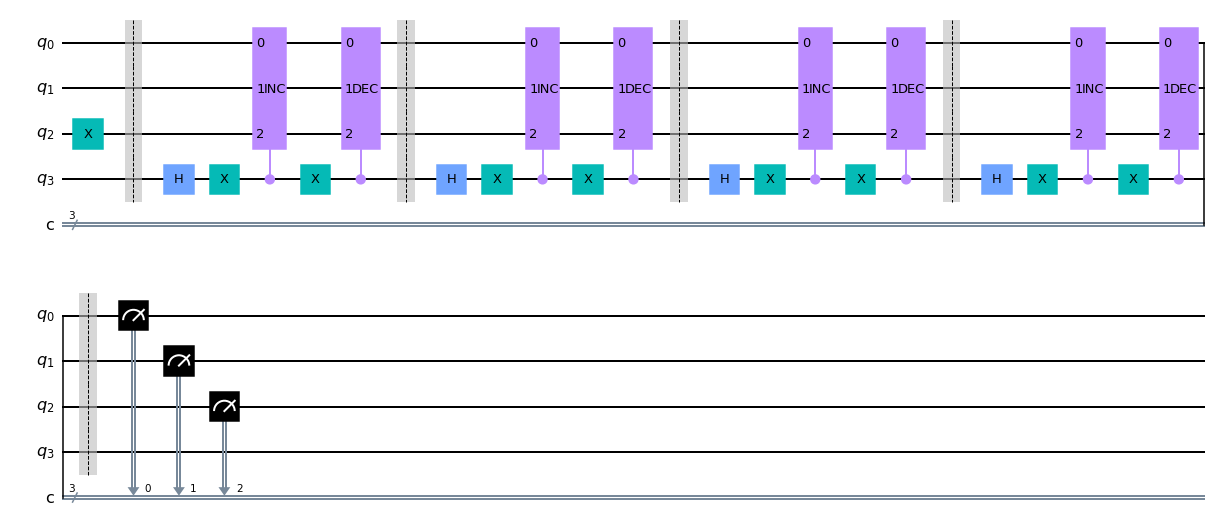

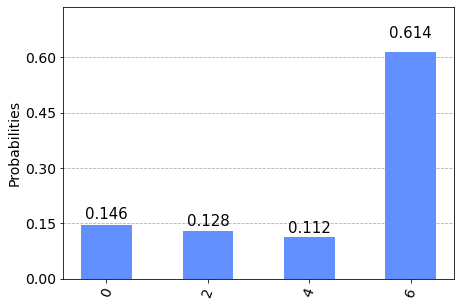

In [54]:
n = 3
steps = 4
shots= 500

qw_qc = QuantumCircuit(n+1,n)
u_inc = c_increment(n)
u_dec = c_decrement(n)

#--- Initial Condition
qw_qc.x(n-1)

qw_qc.barrier()
#--- Diffusion
for t in range(steps):
    qw_qc.h(n)
    qw_qc.x(n)
    qw_qc.append(u_inc, [n]+list(range(0, n)))
    qw_qc.x(n)
    qw_qc.append(u_dec, [n]+list(range(0, n)))
    qw_qc.barrier()

qw_qc.measure(range(n),range(n))
qw_qc.draw('mpl')

backend = Aer.get_backend('qasm_simulator')
result = execute(qw_qc,backend=backend,shots=shots).result().get_counts()
correctedResult = { int(k,2) : v/shots for k, v in result.items()}
plot_histogram(correctedResult)

In [42]:
#N = 3
#steps = 3
#shots = 3000
#display(circRunWalk(N,steps,True).draw(output='mpl',style=styleWide))
#plt.clf()

Let's now analyse if the probability distribution for each step makes sense.

The initial state is

\begin{equation}
	\ket{\Psi(0)} = \ket{0}\ket{4}
\end{equation}

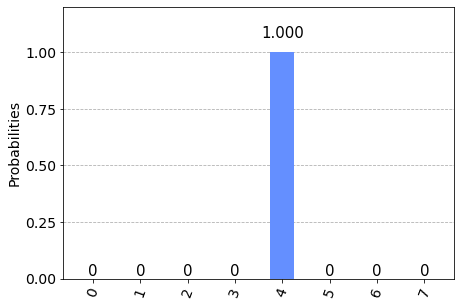

<Figure size 504x360 with 0 Axes>

In [72]:
N = 3
steps = 0
shots = 3000 
qWalk = runWalk(N,steps,False)
result = resultsSim(N,qWalk,shots,True)
display(plot_histogram(result))
plt.clf()

Since we defined the increment gate to act when coin state is $\ket{1}$, the state after the first step is

\begin{equation}
    \ket{\psi(1)} = U \ket{\psi(0)} = \frac{\ket{0}\ket{x=3}}{\sqrt{2}}+\frac{\ket{1}\ket{x=5}}{\sqrt{2}} \\\\
\end{equation}

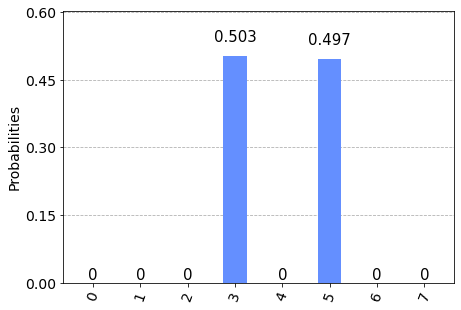

<Figure size 504x360 with 0 Axes>

In [73]:
N = 3
steps = 1
shots = 5000
qWalk = runWalk(N,steps,False)
result = resultsSim(N,qWalk,shots,True)
display(plot_histogram(result))
plt.clf()

Moving on to the second iteration

\begin{equation}
    \ket{\Psi(2)} = \frac{\ket{0}\ket{x=2}}{2}+\frac{(\ket{1}+\ket{0})\ket{x=4}}{2}-\frac{\ket{1}\ket{x=6}}{2}\\\\
\end{equation}

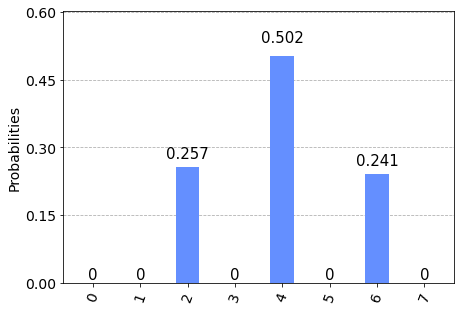

<Figure size 504x360 with 0 Axes>

In [74]:
N = 3
steps = 2
shots = 5000
qWalk = runWalk(N,steps,False)
result = resultsSim(N,qWalk,shots,True)
display(plot_histogram(result))
plt.clf()

And finally, the third step

\begin{equation}
    \ket{\Psi(3)} = \frac{\ket{0}\ket{1}}{2\sqrt{2}}+\frac{(\ket{1}+2\ket{0})\ket{3}}{2\sqrt{2}} - \frac{\ket{0}\ket{5}}{\sqrt{2}}+\frac{\ket{1}\ket{7}}{\sqrt{2}}
\end{equation}


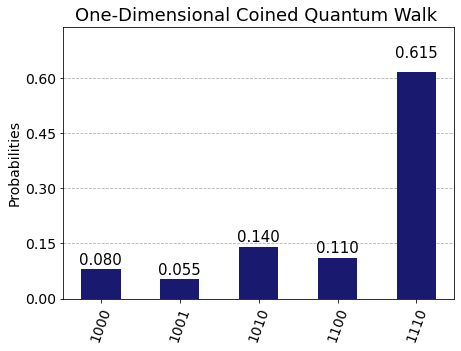

<Figure size 504x360 with 0 Axes>

In [152]:
def incr2(qwc,q,subnode,n):
    qwc.x(subnode[0])
    
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qwc,subnode[0],*q[-1::-1])
            #qwc.barrier()
        else:
            cnx(qwc,subnode[0],*q[-1:j:-1])
           # qwc.barrier()
        
    qwc.x(subnode[0])
    return qwc

def decr2(qwc,q,subnode,n):
    c=0
    qwc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            c+=1
            cnx(qwc,subnode[0],*q[-1::-1])
            qwc.x(q[c])
            qwc.barrier()
        else:
            c+=1
            cnx(qwc,subnode[0],*q[-1:j:-1])
            if(c==n):
                break
            if(c<n-1):
                qwc.x(q[c])
            qwc.barrier()
    return qwc

def runWalk2(N,steps,stateVec):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N)
    qsub = QuantumRegister(1)
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    qwc.x(qreg[N-1])
    #qwc.x(qsub[0])
    #qwc.h(qsub[0])
    #qwc.s(qsub[0])
    for i in range(0,steps):
        qwc.h(qsub[0])
        qwc.barrier()
        incr2(qwc,qreg,qsub,N)
        qwc.barrier()
        decr2(qwc,qreg,qsub,N)
        qwc.barrier()
    if not stateVec:
        qwc.measure(qreg,creg)
    return qwc

N = 4
steps = 4
shots = 3000
#qreg = QuantumRegister(N)
#qsub = QuantumRegister(1)
#qdecr = QuantumCircuit(qreg,qsub)
#qdecr = decr(qdecr,qreg,qsub,N)
#display(qdecr.draw(output='mpl'))
#plt.clf()
qWalk = runWalk2(N,steps,False)
#display(qWalk.draw(output='mpl'))
#plt.clf()
#result = resultsSim(N,qWalk,shots,True)
#display(plot_histogram(result))
backend = Aer.get_backend('qasm_simulator')
result = execute(qWalk,backend=backend).result().get_counts()
display(plot_histogram(result,color='midnightblue', title="One-Dimensional Coined Quantum Walk "))
plt.clf()

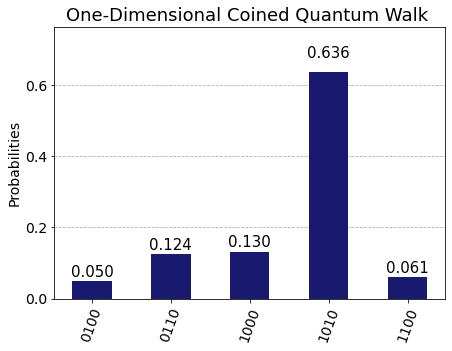

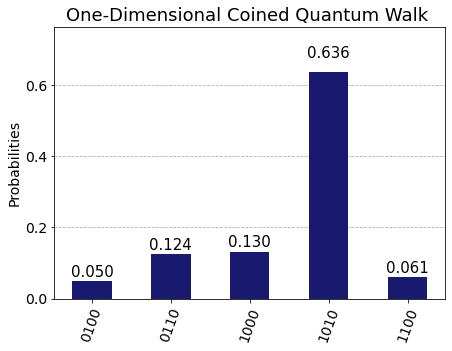

In [140]:
def c_increment(n):
    c_inc = QuantumCircuit(n)
    controls = [x for x in range(n-1)]
    
    for p in range(n-1):
        c_inc.mcx(controls,controls[-1] + 1)
        controls.pop()
        
    c_inc.x(0)
    c_inc = c_inc.to_gate()
    
    c_inc.name = 'INC'
    c_inc = c_inc.control()
    return c_inc
    
def c_decrement(n):
    c_dec = QuantumCircuit(n)
    controls = [x for x in range(n-1)]
    c_dec.x(controls)
    
    for p in range(n-2):
        c_dec.mcx(controls,controls[-1] + 1)
        c_dec.x(controls[-1])
        controls.pop()
        
    c_dec.cx(0,1)
    c_dec = c_dec.to_gate()
    c_dec.name = 'DEC'
    c_dec = c_dec.control()
    return c_dec

n = 4
steps = 4

qw_qc = QuantumCircuit(n+1,n)
u_inc = c_increment(n)
u_dec = c_decrement(n)

#--- Initial Condition
qw_qc.x(n-1)
#qw_qc.h(n)
#qw_qc.s(n)

qw_qc.barrier()
#--- Diffusion
for t in range(steps):
    qw_qc.h(n)
    qw_qc.append(u_dec, [n]+list(range(0, n)))
    qw_qc.x(n)
    qw_qc.append(u_inc, [n]+list(range(0, n)))
    qw_qc.x(n)
    qw_qc.barrier()

qw_qc.measure(range(n),range(n))

backend = Aer.get_backend('qasm_simulator')
result = execute(qw_qc,backend=backend).result().get_counts()
plot_histogram(result,color='midnightblue', title="One-Dimensional Coined Quantum Walk ")

The first few steps of the walk are not unlike the classical walk. In fact, if we were to measure the state after each application, interference between states would not happen and we would just have a regular normal distribution.\par
However, when the quantum walk is allowed to procede without intermediary measurements, the quantum effects become very apparent, as can be seen by state $\psi(3)$. Even though an unbiased coined was used, this state is not symmetric nor centered around the origin.

Decidir se ponho aqui desvio padrao + aplicaçoes

## Continuous-time Quantum Walk

In [22]:
def circulantAdjacency(n,v):
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]    
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def initStateCont(N,initCond): #generalizar isto ?
    psi0 = np.zeros((N,1))
    for x in initCond:
        psi0[x] = 1 / len(initCond)
    return psi0

def final_state(Op,psi0):
    psiN = Op.dot(psi0)
    return psiN

def ct_evo(H,t,gamma):
    U = linalg.expm(-1j*gamma*H*t)
    return U

def prob_vec(psiN,N):
    probs = np.zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*np.conjugate(psiN[x]) 
    return probs

def ctqwalk(N, A, t, gamma, initState):
    psi0 = initState
    U = ct_evo(A,t,gamma)
    psiN = final_state(U,psi0)
    probvec = prob_vec(psiN,N)
    return probvec

The Continuous-time Quantum Walk (CTQW) is an alternative model of a random walk, firstly introduced by \cite{montrollweiss1965}, which does not require a coin. Because time is continuous, the walker can transition from some position $x_i$ to another $x_j$ at any time.

One way to visualize the dynamics is to imagine the probability of the walker transitioning as a fluid that is trickling from position $x_i$ to $x_j$. The probability of it being found in $x_i$ gradually shifts to $x_j$, until the walker eventually moves ahead. The increase and decrease of the probability can be described by a transition rate, $\gamma$, which is constant for all vertices and times.

In order to deal with the continuous variables, we must setup an appropriate differential equation and find it's solutions

\begin{equation}
	\frac{dp_i(t)}{dt} = \gamma \sum_j L_{ij} p_j(t), \label{contWalk}
\end{equation}
where $L$ is the Laplacian defined as $L = A - D$. $A$ is the adjacency matrix that represents each vertex connection, given by

\begin{equation}
	A_{ij} = \begin{cases} 1, & \mbox{if } (i,j)\in G \\ 0, & \mbox{otherwise,} \end{cases}
\end{equation}

and D is the diagonal matrix $D_{jj} = deg(j)$ that represents how many neighbors each vertex has.

In the quantum case, the vertices are quantum states that form the basis for the Hilbert space, which means the vector that describes the probability distribution must be converted to a state vector. The transition matrix must also be converted to an equivalent unitary operator. What is left is the following Shrodinger equation

\begin{equation}
	i\hbar \frac{d\ket{\Psi(x,t)}}{dt} = H \ket{\Psi(x,t)}, \label{shrodinger}
\end{equation}

where $H = -\gamma L$.

Solving the equation results in the evolution operator

\begin{equation}
	U(t) = e^{-iHt} = e^{i(-\gamma L)t} = e^{-i\gamma(A+D)t}
    \label{eq:continuousEvolution}
\end{equation}

For a regular graph, $A$ and $D$ commute. This means that the evolution operator can be written in terms of the adjacency matrix, since the degree will be the identity matrix multipled by some constant making it a global phase

\begin{equation}
	U(t) = e^{-i\gamma A t + i\gamma D t} = e^{-i\gamma A t} e^{i\gamma D t} = \phi(t) e^{-i\gamma A t}.
\end{equation}

In this example we will study the CTQW on a cycle, whose adjacency matrix can be traditionally defined by

\begin{equation}
    A = \sum_{x} \ket{x+1}\bra{x} + \ket{x}\bra{x+1}
\end{equation}

However, this can be seen as an instance of a broader class of graphs, namely \textit{circulant graphs}. This kind of graph is defined by a circulant matrix

\begin{equation}\label{eq:adjc}
A = 
\begin{bmatrix}
c_0&c_{N-1}& \cdots&c_2&c_1 \\
c_1&c_0& c_{N-1}& &c_{2} \\
\vdots & c_1 & c_0 &\ddots & \vdots\\
c_{N-2}& & \ddots&\ddots &c_{N-1}\\
c_{N-1} & c_{N-2} & \cdots & c_1 & c_0\\
\end{bmatrix}.
\end{equation}


We can define the circulant matrix based on the first column vector and an operation, similar to a deque, where we move every element to the following position in a cyclic fashion. In this way, we have the first column vector as
FALAR DAS RESTRICOES PORQUE A MATRIZ CIRCULANTE NAO E HERMITIANO $c_{n-j}=c_j$. torna-a hermitiana
\begin{equation}
    v_1 = [c_0,c_1,\cdots,c_{N-2}, c_{N-1}]^T
\end{equation}
and the deque operation such that

\begin{equation}
    D v_1 =[c_{N-1},c_0,\cdots,c_{N-3}, c_{N-2}]^T = v_2
\end{equation}

In [23]:
N = 5
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
A = circulantAdjacency(N,cCycle)  
print(A)

[[0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]


Now that we have the adjacency matrix, the unitary evolution operator

\begin{equation}
 U(t) = e^{-i\gamma A t}
\end{equation}

can be implemented as

In [29]:
N = 5
cCycle = [0,1] + [0 for x in range(N-3)] + [1] 
A = circulantAdjacency(N,cCycle)

gamma = 1/2*np.sqrt(2)
t = 1
U = linalg.expm(-1j*gamma*A*t)
print(U.round(2))

[[ 0.56-0.j    0.01-0.54j -0.21+0.05j -0.21+0.05j  0.01-0.54j]
 [ 0.01-0.54j  0.56-0.j    0.01-0.54j -0.21+0.05j -0.21+0.05j]
 [-0.21+0.05j  0.01-0.54j  0.56-0.j    0.01-0.54j -0.21+0.05j]
 [-0.21+0.05j -0.21+0.05j  0.01-0.54j  0.56-0.j    0.01-0.54j]
 [ 0.01-0.54j -0.21+0.05j -0.21+0.05j  0.01-0.54j  0.56-0.j  ]]


Meaning that the state of our walk after time $t$ is

\begin{equation}
	\ket{\Psi(t)} = U(t)\ket{\Psi(0)},
\end{equation}

where 

\begin{equation}
	\ket{\Psi(0)} = \ket{0}.
\end{equation}


In [30]:
N=5
psi0 = initStateCont(N,[1])
psiN = U.dot(psi0)
print(psiN.round(2))

[[ 0.01-0.54j]
 [ 0.56-0.j  ]
 [ 0.01-0.54j]
 [-0.21+0.05j]
 [-0.21+0.05j]]


Transforming the amplitudes in probabilities

In [31]:
N=5
probs = np.zeros((N,1))
for x in range(N):
    probs[x]=psiN[x]*np.conjugate(psiN[x]) 
print(probs.round(2))

[[0.3 ]
 [0.31]
 [0.3 ]
 [0.05]
 [0.05]]


<ipython-input-31-6917691cc9ca>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


Putting it all together in the _ctqwalk_ function (available in this notebook) allows us to plot the probability distribution. \par
For this example we consider a CQW, at $t=100$, on cyclic graph with 200 vertices, and $\gamma = \frac{1}{2\sqrt{2}}$.

<ipython-input-22-c3727005052e>:32: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


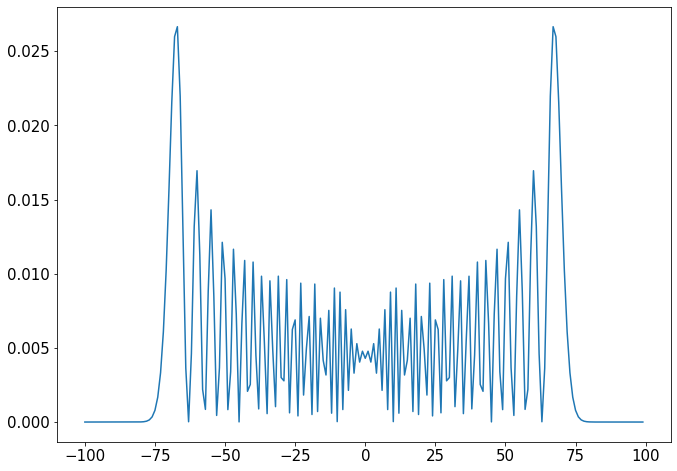

In [32]:
N = 200
t=100
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
gamma = 1/(2*np.sqrt(2))
A = circulantAdjacency(N,cCycle)
initCond = [int(N/2)]
initState = initStateCont(N,initCond)
qw = ctqwalk(N,A,t,gamma,initState)

plt.plot(np.arange(-N/2,N/2),qw)

The choice of initial condition also has an effect on the probability distribution. For example, if

\begin{equation}
	\ket{\Psi(0)} = \frac{\ket{0}+\ket{1}}{\sqrt{2}}
\end{equation}

<ipython-input-22-c3727005052e>:32: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*np.conjugate(psiN[x])


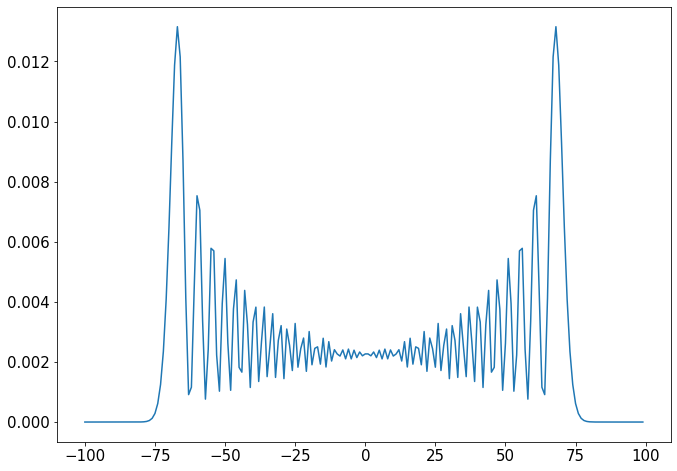

In [33]:
N = 200
t=100
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
denom = 2
gamma = 1/(denom*np.sqrt(2))
A = circulantAdjacency(N,cCycle)
initCond = [int(N/2),int(N/2)+1]
initState = initStateCont(N,initCond)
qw = ctqwalk(N,A,t,gamma,initState)

plt.plot(np.arange(-N/2,N/2),qw)

In both figures we can see several similarities to the probability distribution of the coined quantum walk model. Both have two peaks away from the origin and low probability near the origin. 

<center>
<img src="ctqwMultipleGamma.png" width="800" height="600"/>

In the discrete-time model changing the coin or initial condition would impact both shape and propagation of the walk. However, in the continuous-time model, modifying the transition rate (or time) does influence the propagation but a change in the initial condition does not lead to different numbers of peaks in the distribution.

### Qiskit Implementation

In [161]:
def circulant_adjacency(n,v): #--- it computes an adjacency matrix for the circulant graph
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def unitary_ctqw(gamma, N, A,t): #---
    U = expm(1j*(-gamma*A)*t)
    return U

def diagUniOp(N,diagU0):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,name='    UniOp    ')
    circ.diagonal(diagU0,qreg) 
    circ = transpile(circ)#,optimization_level=3)#,backend=backend,layout_method=method) 
    return circ

def runContCirc(N,diagUniOp,t):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    if t == 0: 
        circ.x(qreg[0])
        circ.measure(qreg,creg)
        circ = transpile(circ)
        return circ 
    else:
        circ.x(qreg[0])
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    IQFT'    ),range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ=transpile(circ,basis_gates=['cx','cp','rz','h','x'])
    return circ


def multDiagUniOp(N,NCirc,gamma,adjacency,time,backend,method):
    unitaryCircList = []
    for t in time:
        U0 = unitary_ctqw(gamma,N,adjacency,[],t)
        diagU0 = np.diag(U0).tolist()
        diagCirc = diagUniOp(NCirc,diagU0,backend,method)
        unitaryCircList.append(diagCirc)
    return unitaryCircList


def multContCirc(N,unitaryList,time,backend,methods):
    circList = []
    circListAux = []
    qreg = QuantumRegister(N)
    qsub = QuantumRegister(1)
    creg = ClassicalRegister(N)
    for t,diagU0 in zip(time,unitaryList):
        circ = QuantumCircuit(qreg,creg)
        circ =  contCirc(N,diagU0,backend,method,t)
        circ = transpile(circ,optimization_level=3,backend=backend, layout_method=method)
        circList.append(circ)
    return circList

def drawCircCont(N,diagU,time,style):
    qreg = QuantumRegister(N,name='qv')
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    circ.x(qreg[0])
    circ.barrier()
    circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    QFT    '),range(N))
    circ.append(diagU,range(N))
    circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    IQFT    '),range(N))
    circ.barrier()
    circ.measure(qreg,creg)
    fig = circ.draw(output='mpl',style=style)
    return fig 

def drawQftCirc(N,style):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    circ = QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    QFT    ')
    circ = transpile(circ, basis_gates=['cp','h','cx','rz'])
    fig = circ.draw(output='mpl',style=style)
    return fig 

def drawDiagUni(N,diagU0,backend,method,style):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,name='    UniOp    ')
    circ.diagonal(diagU0,qreg) 
    circ = transpile(circ,basis_gates=['cp','h','cx','rz'])
    fig = circ.draw(output='mpl',style=style)
    return fig
    
def runContWalk(N,NCirc,t,gamma,c):
    qft = dft(N, scale = 'sqrtn')
    iqft = inv(qft)
    A = iqft@circulant_adjacency(N,c)@qft
    U0 = unitary_ctqw(gamma, N, A,t)
    diagU0 = np.diag(U0).tolist()
    UCirc = diagUniOp(NCirc,diagU0)
    cCirc = runContCirc(NCirc,UCirc,t)
    return cCirc

def resultsSimCont(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = baseResultDict(N,Decimal)
    if Decimal:
        correctedResultAux = { int(k[::-1],2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k[::-1] : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult

The eigenvalues of circulant matrices can be found by

\begin{equation}
\lambda_p = c_0 + \sum_{q=1} c_{N-q} \omega^{pq},
\end{equation}


considering $\omega_j = e^{2\pi i/N}$.

and the associated eigenvectors by

\begin{equation}
\ket{\varphi_p} = \frac{1}{\sqrt{n}} \sum_{q=0}^{n-1} \omega^{pq}
\end{equation}

This is relevant, because it is possible to construct an operator that diagonalizes the circulant matrix through the eigenvectors. For this purpose, we can use the \textit{Quantum Fourier Transform} (QFT) that is defined as

\begin{equation}
F = \frac{1}{\sqrt{N}} \sum_{p,q} \omega^{pq} \ket{p}\bra{q},
\end{equation}

and rewrite the adjacency matrix as 

\begin{equation}
    A = F^{\dagger} \Lambda F \implies \Lambda = F A F^{\dagger} 
    \label{eq:circAdjMatrix},
\end{equation}

where $\Lambda$ is a diagonal operator which encodes the eigenvalues as

\begin{equation}
\Lambda = \sum_{j} \lambda_j \ket{j}\bra{j}.
\end{equation}

Considering the cycle graph case

In [163]:
N = 4
qft = dft(N, scale = 'sqrtn')
iqft = inv(qft)
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
A = circulant_adjacency(N,cCycle)

lambdA = iqft@A@qft 
print(lambdA.round(2))

[[ 2.+0.j -0.-0.j  0.-0.j  0.-0.j]
 [-0.+0.j -0.+0.j -0.-0.j  0.+0.j]
 [ 0.+0.j -0.+0.j -2.+0.j  0.+0.j]
 [-0.+0.j  0.-0.j  0.-0.j -0.-0.j]]


The unitary operator of the walk can then be rewritten as

\begin{equation}\label{eq:diagUniOpCont}
    U(t) =  e^{i\gamma F^{\dagger} \Lambda F t}  =F^{\dagger} e^{i\gamma \Lambda t} F,
\end{equation}

TODO: teorema espectra aplicar uma funcao de matriz\par
where

\begin{equation}
    e^{i\gamma \Lambda t} = \sum_{j} e^{i\gamma \lambda_j t} \ket{j}\bra{j}.
\end{equation}

In [164]:
gamma = 1/(2*np.sqrt(2))
t=1
U0 = expm(1j*(-gamma*lambdA)*t)
print(U0.round(2))

[[ 0.76-0.65j -0.  +0.j   -0.  -0.j   -0.  -0.j  ]
 [ 0.  +0.j    1.  +0.j   -0.  +0.j    0.  -0.j  ]
 [ 0.  +0.j    0.  +0.j    0.76+0.65j  0.  -0.j  ]
 [ 0.  +0.j   -0.  -0.j   -0.  -0.j    1.  +0.j  ]]


Because the evolution operator is now a diagonal matrix, we can use the Qiskit function \textit{diagonal}, which takes the diagonal entries of a matrix and converts them into a circuit based on the following decomposition presented in \cite{Shende06}.

<center>
<img src="diagDecomposition.png" width="1000" height="800"/>

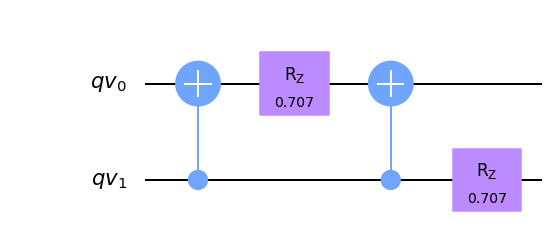

<Figure size 720x306.397 with 0 Axes>

In [166]:
NCirc = 2
qreg = QuantumRegister(NCirc,name='qv')

evoOp = QuantumCircuit(qreg, name='     U     ')
U = np.diag(U0).tolist()
evoOp.diagonal(U,qreg)
evoOp = transpile(evoOp,basis_gates=['cp','h','cx','rz'])
display(evoOp.draw(output='mpl',style=style))
plt.clf()

And the final component is the QFT, whose general circuit is

<center>
<img src="qftcirc.png" width="1000" height="800"/>

where 

\begin{equation}
	R_k = \begin{pmatrix}
		&1 & 0 & \\
		&0 & e^{\frac{2\pi i}{2^k}}
              \end{pmatrix}.
\end{equation}

In Qiskit, the QFT circuit for $2$ qubits will look like

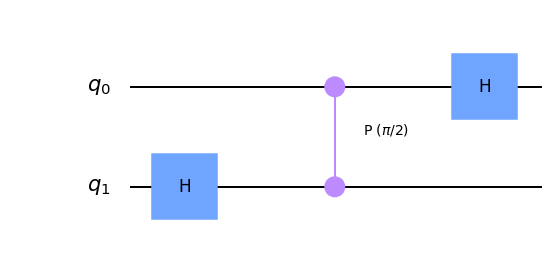

<Figure size 720x317.876 with 0 Axes>

In [74]:
NQft = 2
qreg = QuantumRegister(NQft,name='qv')
qftCirc = QuantumCircuit(qreg) 

qftCirc = QFT(NQft,do_swaps=False,approximation_degree=0,inverse=False,name='    QFT    ')
qftCirc = transpile(qftCirc, basis_gates=['h','cx','rz','cp'])
display(qftCirc.draw(output='mpl',style=style))
plt.clf()

Putting it all together, the overall circuit in Qiskit will be

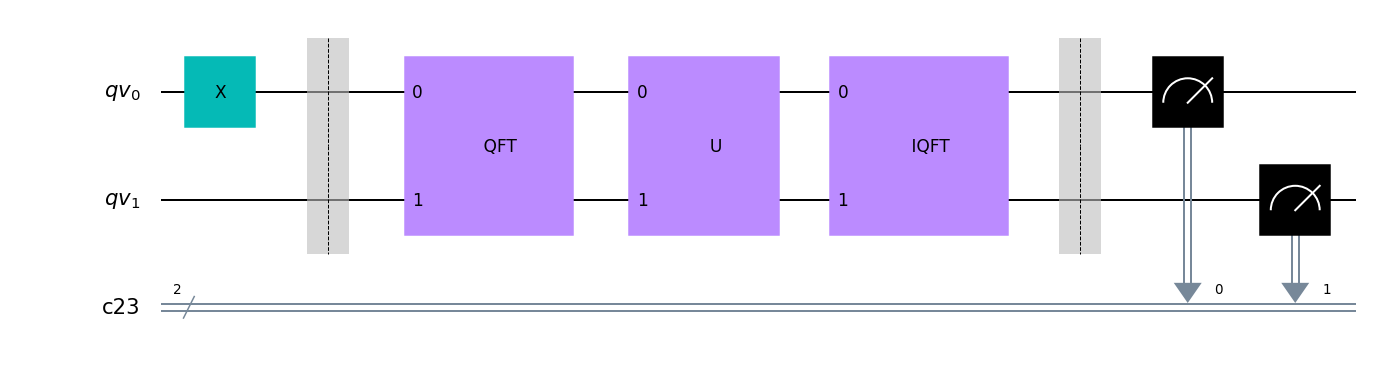

<Figure size 1800x484.187 with 0 Axes>

In [76]:
NCirc = 2
gamma =  1/(2*np.sqrt(2))
t = 1
continuousCirc = drawCircCont(NCirc,evoOp,t,styleWide)

display(continuousCirc)
plt.clf()

To visualize the probability distribution, let's consider the cycle graph again but with $8$ vertices or $N=3$ qubits. For the initial condition $\psi(0) = \ket{4}$, the walk at $t=0$ will result in the following distribution.

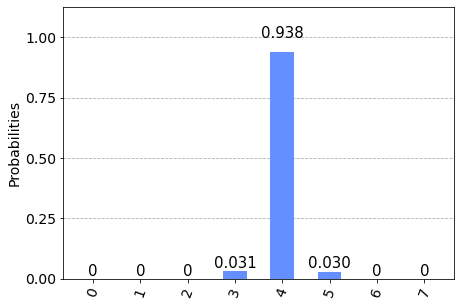

<Figure size 504x360 with 0 Axes>

In [171]:
NCont = 8
NCircCont = 3
gamma =  1/(2*np.sqrt(2))
tCont = 0.5
cCycle = [0,1] + [0 for x in range(NCont-3)] + [1]
shotsCont = 5000

contCirc = runContWalk(NCont,NCircCont,tCont,gamma,cCycle)
resultCont = resultsSimCont(NCircCont,contCirc,shots,True)
display(plot_histogram(resultCont))
plt.clf()

## Search Problems

### Grover's algorithm

In [110]:
def markedListGrover(markedList,N):
    oracleList = np.ones(2**N)
    for element in markedList:
        oracleList[element] = -1
    return oracleList.tolist()

def getOracleGrover(markedList,N):
    oracleList = np.eye(2**N)
    for element in markedList:
        oracleList[element][element] = -1
    return oracleList

def oracleGrover(marked,N):
    markedList = markedListGrover(marked,N)
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg,name='    Oracle    ')
    qc.diagonal(markedList,qreg)
    qc=transpile(qc,optimization_level=3)
    return qc

def diffusionGrover(N):
    qreg = QuantumRegister(N)
    difCirc = QuantumCircuit(qreg,name='     Diff    ')
    difCirc.h(qreg)
    qcAux = oracleGrover([0],N)
    difCirc.append(qcAux,range(N))
    difCirc.h(qreg)
    difCirc=transpile(difCirc,optimization_level=3)
    return difCirc

def runGrover(N,steps,marked):
    qc = QuantumCircuit(N,N)
    qcOracle = oracleGrover(marked,N)
    qcDiffusion = diffusionGrover(N)
    qc.h(range(N))
    for i in range(steps):
        qc.append(qcOracle,range(N))
        qc.barrier()
        qc.append(qcDiffusion,range(N))
        qc.barrier()
    qc.barrier()
    qc.measure(range(N),range(N))
    qc = transpile(qc,optimization_level=1)
    return qc

def drawGroverCirc(N,steps,marked,style):
    qc = QuantumCircuit(N,N)
    qcOracle = oracleGrover(markedListGrover(marked,N),N)
    qcDiffusion = diffusionGrover(N)
    qc.h(range(N))
    qc.barrier()
    for i in range(steps):
        qc.append(qcOracle,range(N))
        qc.append(qcDiffusion,range(N))
        qc.barrier()
    qc.measure(range(N),range(N))
    qc = transpile(qc)
    fig = qc.draw(output='mpl',style=style)
    return qc

def drawOracle(N,marked,style):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg,name='    Oracle    ')
    qc.diagonal(markedListGrover(marked,N),qreg)
    qc=transpile(qc,basis_gates=['cx','rz','ccx','x','h'])
    fig = qc.draw(output='mpl',style=style)
    return fig 

def drawDiffusion(N,style):
    qreg = QuantumRegister(N)
    difCirc = QuantumCircuit(qreg,name='     Diff    ')
    difCirc.h(qreg)
    aux = markedListGrover([0],N)
    qcAux = oracleGrover(aux,N)
    difCirc.append(qcAux,range(N))
    difCirc.h(qreg)
    difCirc=transpile(difCirc,basis_gates=['cx','rz','ccx','x','h'])
    fig = difCirc.draw(output='mpl',style=style)
    return fig

def drawCircGrover(N,steps,marked,style):
    qc = QuantumCircuit(N,N)
    qcOracle = oracleGrover(markedListGrover(marked,N),N)
    qcDiffusion = diffusionGrover(N)
    qc.h(range(N))
    qc.barrier()
    for i in range(steps):
        qc.append(qcOracle,range(N))
        qc.append(qcDiffusion,range(N))
        qc.barrier()
    qc.measure(range(N),range(N))
    qc = transpile(qc)
    fig = qc.draw(output='mpl',style=style)
    return qc

def resultsSimGrover(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = baseResultDict(N,Decimal)
    if Decimal:
        correctedResultAux = { int(k,2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult

Grover's algorithm is a quantum alternative to unstructured search problems. Consider the case of finding element $x_0$ in an unordered list of size $N$. On average, a classical algorithm needs around $\frac{N}{2}$ steps, while Grover's algorithm accomplishes the same in $O(\sqrt{N})$, as was shown by \cite{grover1996}.

The algorithm is as follows
\begin{enumerate}
\item Prepare state $\ket{\Psi_0}  = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1} \ket{x}$;
\item Mark the solution elements with the oracle operator $\mathcal{O} = I - 2\sum_{m\in M} \ket{m}\bra{m}$;
\item Amplitude amplification process with the diffusion operator $ \mathcal{D} = (2\ket{\Psi_0}\bra{\Psi_0} - I) = H^{\otimes n}(2\ket{0}\bra{0} - I)H^{\otimes n}$;
\item Apply operator $U = \mathcal{O} \mathcal{D}$,  $O(\sqrt{N})$ times for maximum amplitude of the marked vertex.
\item Measure the state.
\end{enumerate}


Considering the case where we have $3$ qubits ($N=8$) and one marked element, the optimal number of steps is $\frac{\pi}{4}\sqrt{N} \approx 2$, and the corresponding circuit will be

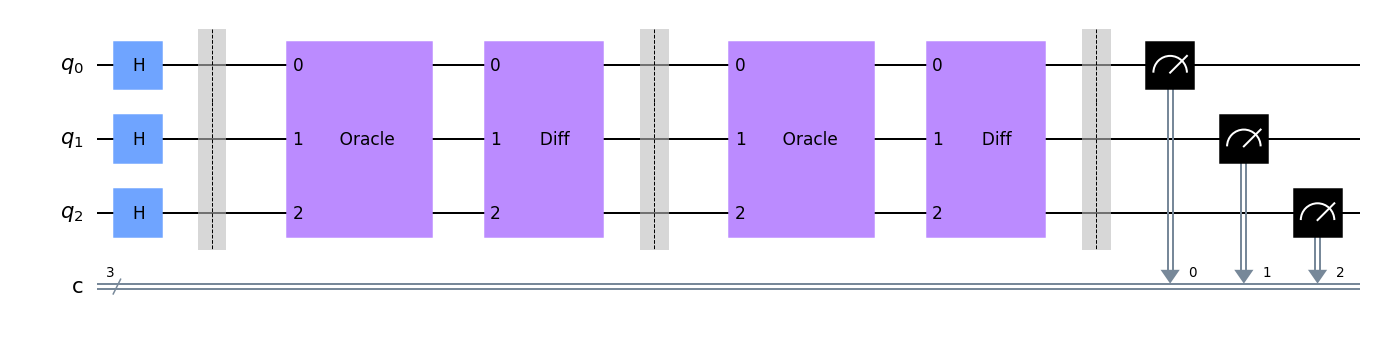

In [78]:
NGrover = 3
stepsGrover = int(ceil((np.pi /4)* (np.sqrt(N))))
markedGrover = [4]
groverCirc = drawCircGrover(NGrover,stepsGrover,markedGrover,styleWide)

Because the oracle operator is a diagonal matrix

\begin{equation}
	\mathcal{O} = I - 2\sum_{m\in M} \ket{m}\bra{m} =
	\begin{pmatrix}
		(-1)^{f(0)} & 0 & \cdots & 0\\
	        0 & (-1)^{f(1)} & \cdots & 0\\ 
	        \vdots & 0 &  \ddots & \vdots\\ 
		0 & 0 & \cdots &  (-1)^{f(N-1)}
	\end{pmatrix}.
	\label{eq:oracleMatrixQiskit}
\end{equation}

where $f(x) = 1$ if $x \in M$, otherwise 0.

In [86]:
NGrover = 3
markedGrover = [4]
oracleMatrixGrover = np.eye(2**NGrover)

for element in markedGrover:
    oracleMatrixGrover[element][element] = -1
print(oracleMatrixGrover)

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


We can use the \textit{diagonal} function to generate the circuit

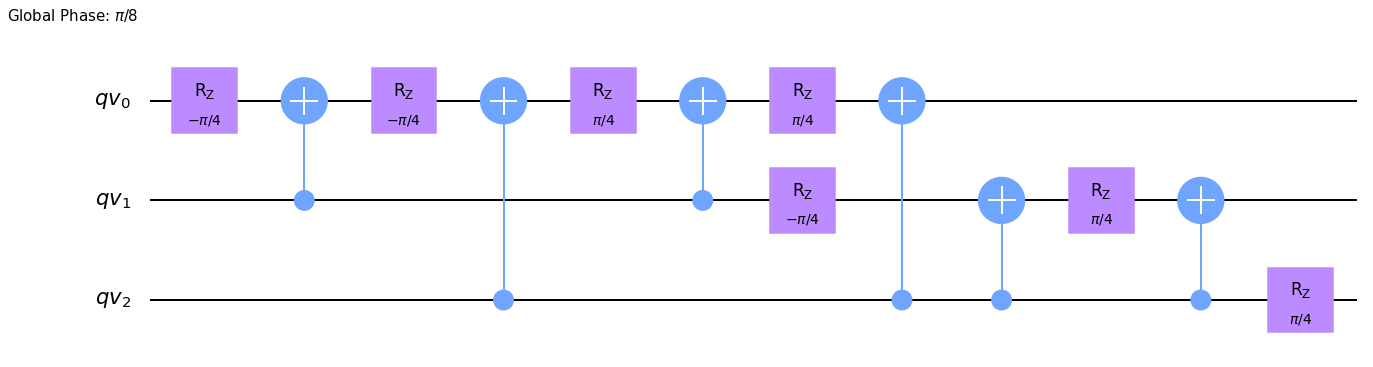

<Figure size 1800x448.609 with 0 Axes>

In [88]:
NGrover = 3
diagOracle = np.diag(oracleMatrixGrover).tolist()
qreg = QuantumRegister(N,name='qv')
qcOracle = QuantumCircuit(qreg)

qcOracle.diagonal(diagOracle,qreg)
qcOracle = transpile(qcOracle,basis_gates=['cx','rz'])
display(qcOracle.draw(output='mpl',style=styleWide))
plt.clf()

As we saw, the diffusion operator is

\begin{equation}
        \mathcal{D} = H^{\otimes n}(2\ket{0}\bra{0} - I)H^{\otimes n}.
\end{equation}

In order to implement this circuit, this definition is very useful since it tells us the diffusion operator is simply an inverted oracle with hadarmads before and after the operation.

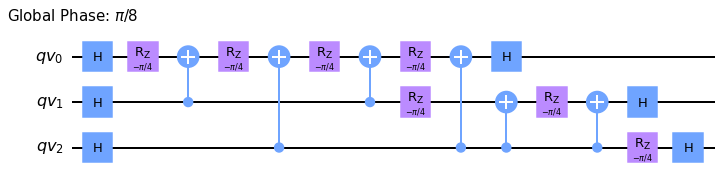

<Figure size 941.658x204.68 with 0 Axes>

In [99]:
NGrover = 3
qreg = QuantumRegister(NGrover,name='qv')
qcDiffusion = QuantumCircuit(qreg)
oracleAux = oracleGrover([0],NGrover)

qcDiffusion.h(qreg)
qcDiffusion.append(oracleAux,range(N))
qcDiffusion.h(qreg)
qcDiffusion = transpile(qcDiffusion,basis_gates=['cx','rz','h'])
display(qcDiffusion.draw(output='mpl'))
plt.clf()

Putting it all together, the probability distribution for one marked element after $2$ steps is

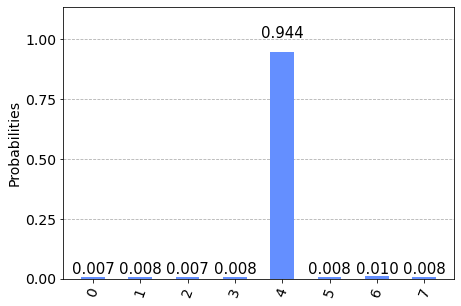

<Figure size 504x360 with 0 Axes>

In [127]:
NGrover = 3
steps = floor((np.pi /4)* (np.sqrt(2**NGrover)))
markedGrover = [4]
shots = 5000

groverCirc = runGrover(NGrover,steps,markedGrover)
resultsGrover = resultsSimGrover(NGrover,groverCirc,shots,True)
display(plot_histogram(resultsGrover))
plt.clf()

Considering more than one marked element, say $K$ solutions for the searching problem, the optimum number of iterations is

\begin{equation}
	 \frac{\pi}{4}\sqrt{\frac{N}{K}}
\end{equation}

as was shown by \cite{boyer1996}. \par
For a $16$ element search space, it is expected that a $2$ marked element search requires $\frac{\pi}{4}\sqrt{\frac{16}{2}} \approx 2$ steps.

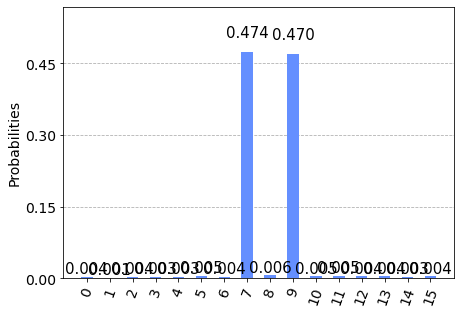

<Figure size 504x360 with 0 Axes>

In [130]:
NGrover = 4
steps = floor((np.pi/4) * np.sqrt(2**NGrover/2))
markedGrover = [7,9]
shots = 5000

groverCirc = runGrover(NGrover,steps,markedGrover)
resultsGrover = resultsSimGrover(NGrover,groverCirc,shots,True)
display(plot_histogram(resultsGrover))
plt.clf()

An interesting case is when the number of marked elements represents $\frac{1}{4}$ of the total elements. This is usually called \textit{single-shot} Grover's algorithm since 

\begin{equation}
 	 \frac{\pi}{4} \sqrt{ \frac{N}{\frac{N}{4}} } = \frac{\pi}{4}\sqrt{\frac{N}{4N}} = \frac{\pi}{4}\frac{1}{2} \approx 1
\end{equation}

which means that a single iteration of the circuit is optimum regardless of the size of the search space, when one fourth of the elements are solutions.

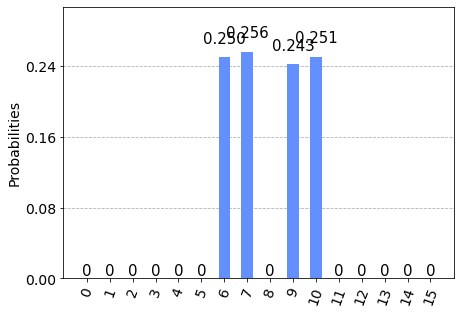

<Figure size 504x360 with 0 Axes>

In [129]:
NGrover = 4
steps = floor((np.pi/4) * np.sqrt(2**NGrover/4))
markedGrover = [6,7,9,10]
shots = 5000

groverCirc = runGrover(NGrover,steps,markedGrover)
resultsGrover = resultsSimGrover(NGrover,groverCirc,shots,True)
display(plot_histogram(resultsGrover))
plt.clf()

### Continuous-time Quantum Walk

The unitary evolution operator presented in equation \ref{eq:continuousEvolution} can be modified as to accomodate an oracle 

\begin{equation}
	U'(t) = e^{-iH't} = e^{-i\gamma (L + O)t}
\end{equation}

where $H' = -\gamma(L+O)$, $L = A-D$ and the oracle is defined as 

\begin{equation}
	O = \sum_{m \in M} \ket{m}\bra{m}.
\end{equation}

In this example, we consider a complete graph whose vertices are all adjacent to one another.

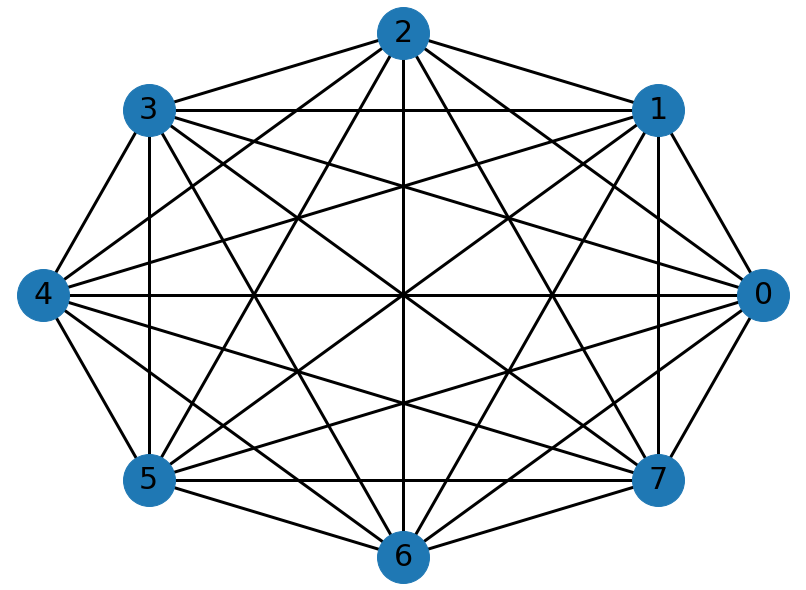

In [21]:
nx.draw_circular(GComplete, with_labels = True,node_size=2700,width=3,font_size=30)

This graph is also regular, which means that the adjacency matrix and degree matrix commute. Therefore, the unitary evolution operator will be

\begin{equation}
	U'(t) = e^{-i\gamma ((A-D) + O)t} = \phi(t) e^{-i\gamma(A+O)t} = e^{-i\gamma(A+O)t}
\end{equation}

However, the adjacency matrix and oracle operator do not commute, which means we need to use the Suzuki-Trotter expansion

\begin{equation}
	e^{i(H_0+H_1)t}=\lim_{n \rightarrow \infty}(e^{i\frac{H_0t}{n}}e^{i\frac{H_1t}{n}})^n ,
\end{equation}

where $n$ is the Trotter number. 

The modified evolution operator can then be rewritten as

\begin{equation}
    U'(t) = e^{-i\gamma(A+O)t} = \lim_{n \rightarrow \infty}(e^{i\frac{\mathcal{O}t}{n}}e^{i\frac{At}{n}})^n
\end{equation}

Remember from equation \ref{eq:circAdjMatrix}

\begin{equation}\label{eq:diag_adj}
    A = F^{\dagger} \Lambda F,
\end{equation}

$U'(t)$ will become

\begin{equation}
	U'(t) =\lim_{n \rightarrow \infty}(F^{\dagger} e^{i\gamma\frac{\Lambda t}{n}} F e^{i\gamma\frac{Ot}{n}})^n .
	\label{eq:suzTrotter}
\end{equation}

This representation is useful, because it allows us to construct a circuit very directly.

<center>
<img src="contsearchcircuit.png" width="1000" height="800"/>

Since both the oracle and the modified evolution operator are diagonal matrices, they can be easily implemented in Qiskit.

Because we cannot apply the operations in the box an infinite number of times, our circuit will only be an approximation. However, for a circuit with $3$ qubits, a Trotter number of $2$ will be sufficient to guarantee the success of the search to a satisfactory degree.

<center>
<img src="ContQW_N3_S1.png" width="900" height="700"/>

This searching problem reaches maximum probability after $\frac{\pi}{2}\sqrt{N}$ steps, as was shown by \cite{janmark2014}. However, due to the Trotter approximation, our circuit will require more and more resources as the number of qubits increases, not only because the size of our search is larger but also because we need to apply more and more iterations of the search in order to get the probability as close to 1 as possible.

# References

(<a id="cit-douglaswang07" href="#call-douglaswang07">Douglas and B., 2009</a>) Douglas B.L. and B. J., ``_Efficient quantum circuit implementation of quantum walks_'', , vol. , number , pp. ,  2009.

(<a id="cit-barenco95" href="#call-barenco95">Barenco, Bennett <em>et al.</em>, 1995</a>) Barenco Adriano, Bennett Charles H., Cleve Richard <em>et al.</em>, ``_Elementary gates for quantum computation_'', Physical Review A, vol. 52, number 5, pp. 3457–3467, Nov 1995.  [online](http://dx.doi.org/10.1103/PhysRevA.52.3457)

(<a id="cit-montrollweiss1965" href="#call-montrollweiss1965">Waters and Herbert, 1997</a>) Waters Elliott and Herbert George, ``_Random walks on lattices. II_'', Journal of Mathematical Physics, vol. , number , pp. 167–181,  1997.  [online]()

(<a id="cit-Shende06" href="#call-Shende06">Shende, Bullock <em>et al.</em>, 2006</a>) Shende V.V., Bullock S.S. and Markov I.L., ``_Synthesis of quantum-logic circuits_'', IEEE Transactions on Computer-Aided Design of Integrated Circuits and Systems, vol. 25, number 6, pp. 1000–1010, Jun 2006.  [online](http://dx.doi.org/10.1109/TCAD.2005.855930)

(<a id="cit-grover1996" href="#call-grover1996">K., 1996</a>) K. Lov, ``_A Fast Quantum Mechanical Algorithm for Database Search_'', STOC '96 Proceedings of the twenty-eighth annual ACM symposium on Theory of computing, vol. , number , pp. 212-219,  1996.  [online]()

(<a id="cit-boyer1996" href="#call-boyer1996">Boyer, Brassard <em>et al.</em>, 1998</a>) Boyer Michael, Brassard Gilles, Høyer Peter <em>et al.</em>, ``_Tight Bounds on Quantum Searching_'', Fortschritte der Physik, vol. 46, number 4-5, pp. 493-505,  1998.  [online]()

(<a id="cit-janmark2014" href="#call-janmark2014">Janmark, Meyer <em>et al.</em>, 2014</a>) Janmark Jonatan, Meyer David A. and Wong Thomas G., ``_Global Symmetry is Unnecessary for Fast Quantum Search_'', Physical Review Letters, vol. 112, number 21, pp. , May 2014.  [online](http://dx.doi.org/10.1103/PhysRevLett.112.210502)

